## Youtube Trend Analysis
- Which months, time of the day, day of the week are most popular for uploads?
- Who are the top channels?
- What are the most common words used in titles? What is the relationship between these words and their views?
- What are the most popular tags? Which are the most liked / disliked tags?
- What kinds of videos get the most comments?

### Preprocessing:
- Create date columns: hour, day, month
- Parse keywords from titles, lowercase
- Parse keywords from tags
- Link category ids to categories

### Analysis:
- Find trends between comments, likes, dislikes and channel / date / tags

### Load dataset, preprocessing

In [142]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
import json

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
path = '/Users/christinejiang/Documents/Python/personal_projects/youtube_trends/'
videos = pd.read_csv(path+'USvideos.csv')
videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [3]:
display(videos.describe())
print(videos.shape)

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


(40949, 16)


In [169]:
#create date columns
videos['pd_datetime'] = pd.to_datetime(videos['publish_time'])
videos['date'] = videos['pd_datetime'].dt.date
videos['day'] = videos['pd_datetime'].dt.day
videos['hour'] = videos['pd_datetime'].dt.hour
videos['month'] = videos['pd_datetime'].dt.month
videos['year'] = videos['pd_datetime'].dt.year
videos['weekday'] = videos['pd_datetime'].dt.day_name()
print('date columns created')

#create keyword column from titles
#lowercase all of the titles, then strip punctuation
#the r in front of the bracket represents raw string notation, so don't treat backslashes as escape characters
#if not using raw string, will use bracket as escape notation
#\w is anything alphanumeric (letters or numbers)
#\s are whitespace characters
#^ complements the set, so matches anything that is not included
#re.sub(r'[^\w\s]','',x) means substitute any non whitespace/alphanumeric character with nothing 
videos['cleaned_title'] = [re.sub(r'[^\w\s]', '', x) for x in videos['title'].str.lower()]
print('clean title created')

#create column of lemmatized sentence
#for the tokenized version of each sentence, lemmatize each word and return if not a stopword and length > 2, join with a space
#apply lambda function to cleaned title, which has no punctuation
lemmatizer = WordNetLemmatizer()
stopword_list = stopwords.words('english')
lem_title = lambda title: [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(title) 
                            if word not in stopword_list and len(word) > 2]
videos['keywords'] = videos['cleaned_title'].apply(lem_title)
print('titles lemmatized')

#create bag of words by splitting lemmatized titles, adding to bow list
#extend combines lists, append adds lists to lists
#count word frequency
bow = []
for word_list in videos['keywords']:
    bow.extend(word_list)
counts = Counter(bow)
title_counts = pd.DataFrame.from_dict(counts, orient='index').sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'count'})
top_200_list = list(title_counts['word'][0:200].values)
print('top 200 words collected')

#create count of top 200 words in lemmatized title
top_200_counter = lambda keywords: sum(word in top_200_list for word in keywords)
videos['top_200_count'] = videos['keywords'].apply(top_200_counter)

#map category IDs to categories
with open(path+'category_mappings.json') as f:
    data = json.load(f)
category_dict = {int(item['id']): item['snippet']['title'] for item in data['items']}
videos['category_name'] = videos['category_id'].map(category_dict)
print('categories mapped')

#create categorical column for weekdays
videos['weekday_cat'] = pd.Categorical(videos['weekday'], 
                                       categories=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday'],
                                      ordered=True)
print('weekday order created')

videos.head()

date columns created
clean title created
titles lemmatized
top 200 words collected
categories mapped
weekday order created


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,day,hour,month,year,weekday,cleaned_title,keywords,top_200_count,weekday_cat,category_name
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,13,17,11,2017,Monday,we want to talk about our marriage,"[want, talk, marriage]",1,Monday,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,13,7,11,2017,Monday,the trump presidency last week tonight with jo...,"[trump, presidency, last, week, tonight, john,...",4,Monday,Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,12,19,11,2017,Sunday,racist superman rudy mancuso king bach lele ...,"[racist, superman, rudy, mancuso, king, bach, ...",1,Sunday,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,13,11,11,2017,Monday,nickelback lyrics real or fake,"[nickelback, lyric, real, fake]",2,Monday,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,12,18,11,2017,Sunday,i dare you going bald,"[dare, going, bald]",0,Sunday,Entertainment


### Exploratory analysis

#### Insights:
- 2-6pm is most popular time for uploads
- views/comments are highest at 4am and 9am; there might be a few results skewing this
- metrics for months are incomplete
- uploads are more common during the week, but most liked / commented on sundays and fridays
- trending videos started picking up at the end of 2017
- mondays have the highest peaks for views

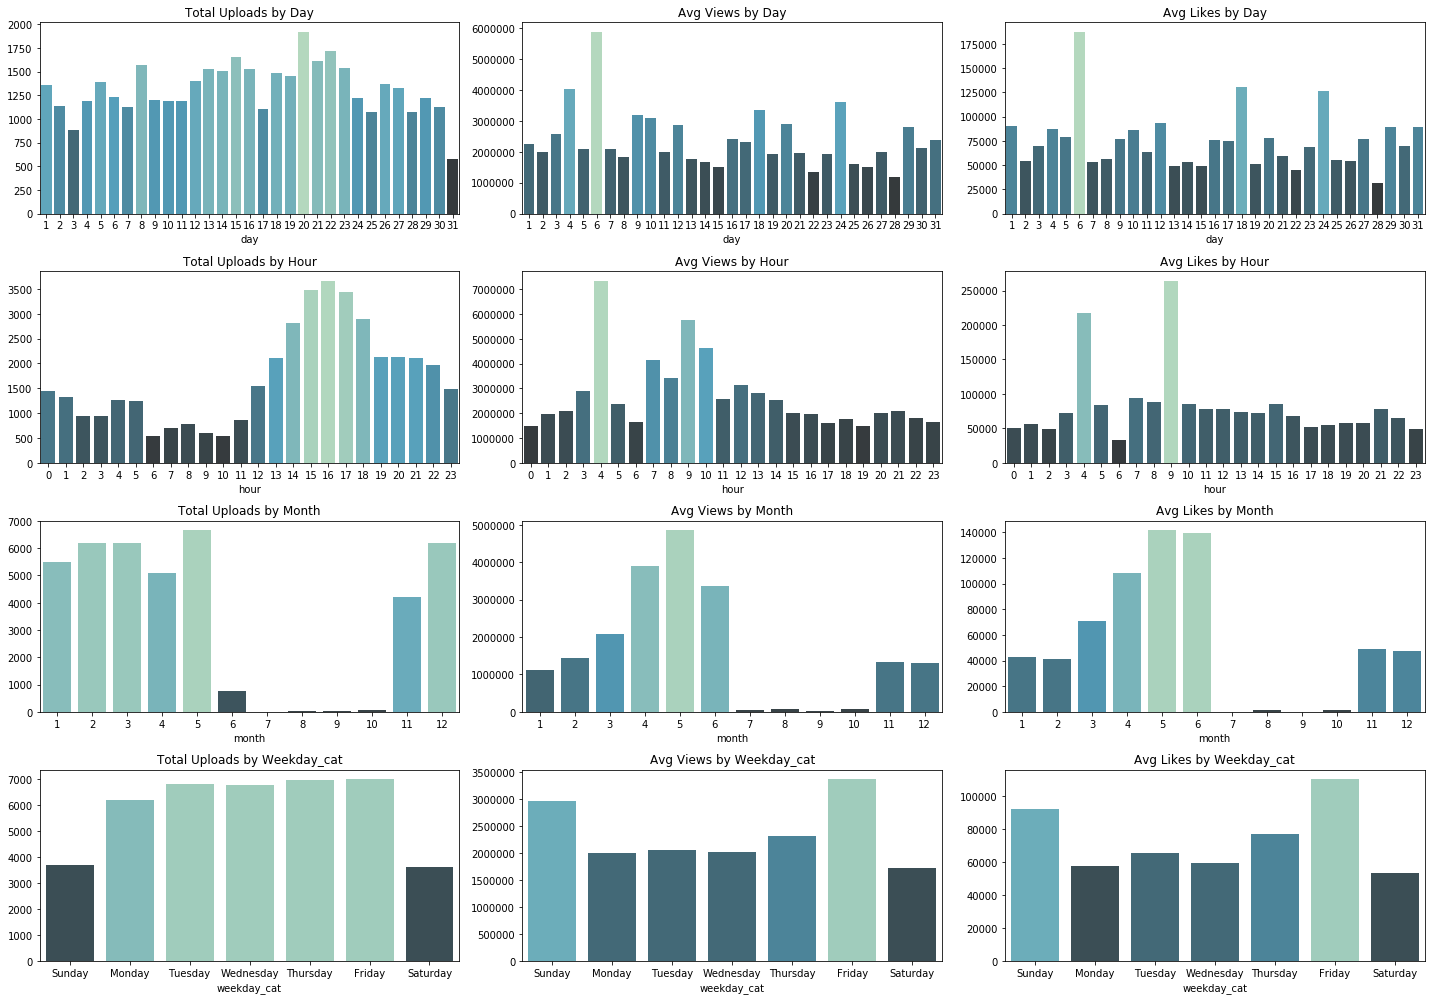

In [133]:
#normalize groupby values 0-1
#convert normalized values to indices (integers)
#retrieve palette with corresponding colors, given number of values
#return array of arrays, where each inner array is the color values assigned to a bar
def colors_from_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    final_palette = np.array(palette).take(indices, axis=0)
    return final_palette

figure,axes = plt.subplots(4,3,figsize=(20,14))
plots = list(axes.flatten())
categories = ['day','hour','month', 'weekday_cat']
for i, (category, color) in enumerate(zip(categories, colors)):
    views = videos.groupby(category)['views'].mean().rename('Avg Views')
    uploads = videos.groupby(category)['video_id'].count().rename('Total Uploads')
    likes = videos.groupby(category)['likes'].mean().rename('Avg Likes')
    for x, count in enumerate([uploads, views, likes]):
        sns.barplot(count.index, count.values, ax=axes[i,x], palette=colors_from_values(count.values, "GnBu_d"))
        axes[i,x].set_title(count.name +' by '+category.capitalize())
figure.tight_layout()

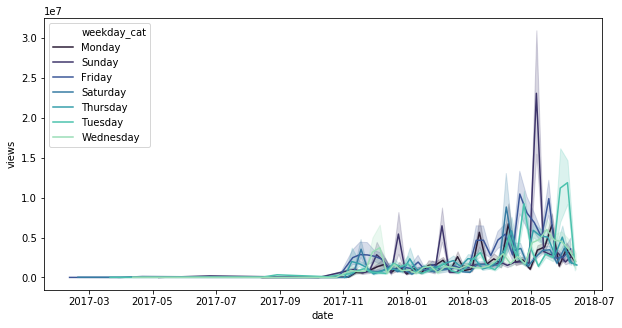

In [135]:
videos_2018 = videos.loc[videos['year']>=2017]
sns.lineplot(x='date', y='views', data=videos_2018, hue='weekday_cat', palette='mako')